# Evolving sorting networks through coevolution

In this lab session we are going to leverage **coevolution** to evolve **sorting networks**.

Sorting networks are algorithms designed to arrange a sequence of elements into a specific order, usually ascending or descending. The key feature of sorting networks is that they use a fixed set of comparisons and swaps to achieve the sorting, and this set of operations is independent of the input data ([wikipedia](https://en.wikipedia.org/wiki/Sorting_network)).

We will represent networks as lists of comparators, where each comparator is a pair of indices indicating which elements to compare.

First of all, we import the random module and set the seed.

In [43]:
import random
random.seed(0)

Let us define a function which sorts an array with a given sorting network.

In [44]:
def eval_sorting_network(sn, array):
    array = array.copy()
    for i, j in sn:
        if array[i] > array[j]:
            array[i], array[j] = array[j], array[i]
    return array

In [45]:
sn=[(0,2), (1,3), (0,3), (1,2), (0,1), (2,3)]
eval_sorting_network(sn, [1,7,2,3])

[1, 2, 3, 7]

Now, we write the code to initialize the 2 competing populations: one for the networks and one for the arrays.

In [46]:
def get_random_network(value_range, depth):
    return [tuple(sorted(random.sample(value_range, k=2))) for _ in range(depth)]

In [47]:
def init_array_population(value_range, dim, pop_size):
    return [random.choices(value_range, k=dim) for _ in range(0, pop_size)]

def init_network_population(value_range, min_depth, max_depth, pop_size):
    pop = []
    for _ in range(pop_size):
        depth = random.choice(range(min_depth, max_depth+1))
        pop.append(get_random_network(value_range, depth))
    return pop

Let us define the 2 fitness functions. A network will have good fitness if it can sort many arrays, while an array will have good fitness if it can 'trick' many networks.

In [48]:
def net_fitness(net_pop, arr_pop, k=10):
    net_scores = [0]*len(net_pop)
    idx_list = range(len(arr_pop))
    for _ in range(k):
        shuffled = random.sample(idx_list, len(idx_list))
        for idx, sn in enumerate(net_pop):
            arr = arr_pop[shuffled[idx]]
            if eval_sorting_network(sn, arr) == sorted(arr): # if the array is sorted correctly, we increase the score
                net_scores[idx] += 1
    return net_scores

def arr_fitness(net_pop, arr_pop, k=10):
    arr_scores = [0]*len(arr_pop)
    idx_list = range(len(arr_pop))
    for _ in range(k):
        shuffled = random.sample(idx_list, len(idx_list))
        for idx, sn in enumerate(net_pop):
            arr = arr_pop[shuffled[idx]]
            if eval_sorting_network(sn, arr) != sorted(arr): # if the network is fooled, we increase the score
                arr_scores[shuffled[idx]] += 1
    return arr_scores

We now implement the tournament selection and the crossover. We can use the same functions for both the populations.

In [49]:
def tournament_selection(pop, scores, k):
  tournament = random.choices(range(len(pop)), k=k)
  selected = max([(scores[idx], pop[idx]) for idx in tournament])
  return selected[1]

In [50]:
def one_point_crossover(x, y):
  n = len(x)
  k = random.randint(0,n-1)
  of1 = x[0:k] + y[k:n]
  #of2 = y[0:k] + x[k:n]
  return of1#, of2

We can now implement a mutation function for the arrays.

In [51]:
def array_mutation(x, value_range, p_m):
  def mutate(v):
    if random.random() < p_m:
        res = random.choice(value_range)
        while res == v: # we avoid sampling the same value
            res = random.choice(value_range)
        return res
    else:
      return v
  return [mutate(v) for v in x]

Now, we can choose one or more mutation operators for the sorting networks. You can use different ones during the evolution.

In [52]:
def add_mutation(sn, value_range):
    idx = random.choice(range(len(sn)))
    comp = tuple(sorted(random.sample(value_range, k=2)))
    return sn[:idx] + [comp] + sn[idx:]

def remove_mutation(sn):
    idx = random.choice(range(len(sn)))
    return sn[:idx] + sn[idx+1:]

def switch_mutation(sn, value_range, p_m):
    for idx, comp in enumerate(sn):
        if random.random() < p_m: # in this case, we change the comparator with a random one
            new_comp = tuple(sorted(random.sample(value_range, k=2)))
            while comp == new_comp: # we make sure not to sample the same one
                comp = tuple(sorted(random.sample(value_range, k=2)))
            sn = sn[:idx] + [new_comp] + sn[idx+1:]
    return sn

def change_end_mutation(sn, value_range, p_m):
    for idx, comp in enumerate(sn):
        if random.random() < p_m:
            pos = random.choice([0,1]) # we change either the left or the right end of the comparator
            new_comp = comp.copy()
            new_comp[pos] = random.choice(value_range)
            while comp == new_comp or new_comp[0]==new_comp[1]:
                new_comp[pos] = random.choice(value_range)
            sn = sn[:idx] + [tuple(sorted(new_comp))] + sn[idx+1:]
    return sn

We have now all the elements to write the code for a generation.

In [53]:
def get_best(pop, scores):
  return max(list(zip(scores, pop)))

In [54]:
def generation(net_pop, arr_pop, net_scores, arr_scores, crossover, arr_dim, value_range, p_m, t_size):
  pop_size = len(net_pop)
  # perform selection for both the populations
  selected_net = [tournament_selection(net_pop, net_scores, t_size) for _ in range(0, pop_size)]
  selected_arr = [tournament_selection(arr_pop, arr_scores, t_size) for _ in range(0, pop_size)]
  # perform crossover
  pairs_net = zip(selected_net, selected_net[1:] + selected_net[0:1])
  pairs_arr = zip(selected_arr, selected_arr[1:] + selected_arr[0:1])
  offspring_net = [crossover(*pair) for pair in pairs_net]
  offspring_arr = [crossover(*pair) for pair in pairs_arr]
  # apply the mutation operator(s) to the offspring
  net_pop = list(map(lambda x: switch_mutation(x, range(arr_dim), p_m), offspring_net))
  arr_pop = list(map(lambda x: array_mutation(x, value_range, p_m), offspring_arr))
  return net_pop, arr_pop

We can now define our `coevolution` function.

In [55]:
def coevolution(value_range, 
                pop_size,
                arr_dim,
                min_depth,
                max_depth,
                net_fit,
                arr_fit,
                crossover,
                t_size = 10, 
                n_gen = 200,
                k_fit = 50):
  
  p_m = 1/arr_dim
  # initialize the population
  Pt = init_network_population(range(arr_dim), min_depth, max_depth, pop_size)
  Qt = init_array_population(value_range, arr_dim, pop_size)

  net_scores = net_fit(Pt, Qt, k_fit)
  arr_scores = arr_fit(Pt, Qt, k_fit)
  net_history = [get_best(Pt, net_scores)[0]]
  arr_history = [get_best(Qt, arr_scores)[0]]
  
  for _ in range(0, n_gen):
    Ptm1 = Pt
    Qtm1 = Qt
    Pt, Qt = generation(Ptm1, Qtm1, net_scores, arr_scores, crossover, arr_dim, value_range, p_m, t_size)
    net_scores = net_fit(Pt, Qtm1, k_fit)
    arr_scores = arr_fit(Ptm1, Qt, k_fit)
    net_history.append(get_best(Pt, net_scores)[0])
    arr_history.append(get_best(Qt, arr_scores)[0])
    
  return get_best(Pt, net_scores)[1], get_best(Qt, arr_scores)[1], net_history, arr_history

Try your code for different array dimensions and parameters.

In [56]:
best_net, best_arr, net_history, arr_history = coevolution(
    value_range=range(50), 
    pop_size=500,
    arr_dim=10,
    min_depth=15,
    max_depth=50,
    net_fit=net_fitness,
    arr_fit=arr_fitness,
    crossover=one_point_crossover,
    t_size = 10,
    n_gen = 200,
    k_fit = 50
    )

In [57]:
print(best_net)
print(best_arr)

[(1, 5), (0, 8), (3, 9), (3, 6), (0, 6), (6, 8), (7, 8), (2, 3), (0, 7), (0, 4), (1, 4), (4, 7), (5, 7), (1, 8), (3, 5), (5, 6), (0, 6), (6, 9), (1, 6), (1, 2), (7, 8), (4, 6), (3, 4), (0, 1), (0, 6), (2, 3), (4, 6), (3, 4), (6, 9), (6, 7), (8, 9), (4, 5), (3, 4), (1, 2), (2, 3), (7, 8), (5, 6), (5, 6)]
[45, 42, 31, 0, 47, 1, 5, 25, 27, 21]


In [58]:
random_arr = random.sample(range(50), k = 10)
print(random_arr)
eval_sorting_network(best_net, random_arr)

[36, 16, 28, 21, 35, 31, 12, 20, 43, 9]


[9, 12, 16, 20, 21, 28, 31, 35, 36, 43]

In [59]:
eval_sorting_network(best_net, best_arr)

[0, 1, 5, 21, 25, 27, 31, 42, 45, 47]

Plot the evolution of the fitness score of the best individual for both populations

In [60]:
import matplotlib.pyplot as plt

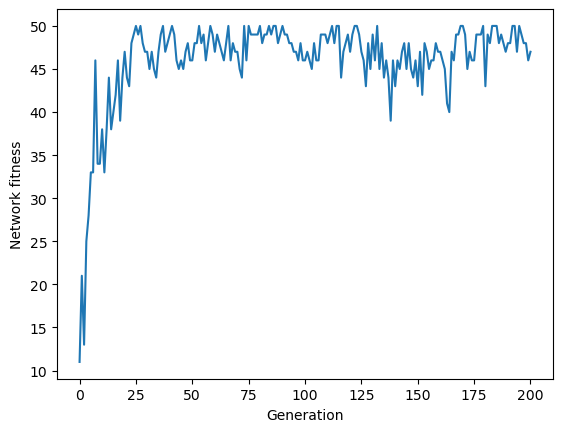

In [61]:
plt.plot(net_history)
plt.ylabel('Network fitness')
plt.xlabel('Generation')
plt.show()

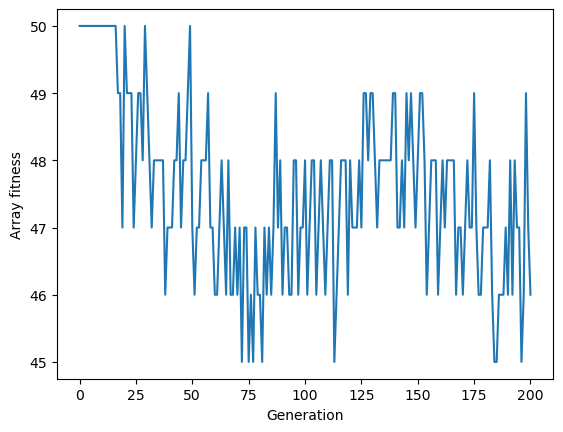

In [62]:
plt.plot(arr_history)
plt.ylabel('Array fitness')
plt.xlabel('Generation')
plt.show()